In [1]:
from Yugiquery import *
header()

<div align='center'>
    <br>
    <pre>
    ██    ██ ██    ██  ██████  ██  ██████  ██    ██ ███████ ██████  ██    ██ 
     ██  ██  ██    ██ ██       ██ ██    ██ ██    ██ ██      ██   ██  ██  ██  
      ████   ██    ██ ██   ███ ██ ██    ██ ██    ██ █████   ██████    ████   
       ██    ██    ██ ██    ██ ██ ██ ▄▄ ██ ██    ██ ██      ██   ██    ██    
       ██     ██████   ██████  ██  ██████   ██████  ███████ ██   ██    ██    
                                      ▀▀                                     
    </pre>
</div>
<div align='right'>
     - Last modified: 14/12/2022 12:14 UTC <br>
    By <b>Guilherme Ruiz</b>
</div>

Table of Contents
=================

*   [1  Data aquisition](#Data-aquisition)
    *   [1.1  Fetch online data](#Fetch-online-data)
    *   [1.2  Format data](#Format-data)
    *   [1.3  Save data](#Save-data)
*   [2  Check changes](#Check-changes)
    *   [2.1  Load latest file](#Load-latest-file)
    *   [2.2  Generate changelog](#Generate-changelog)
*   [3  Data visualization](#Data-visualization)
    *   [3.1  Full data](#Full-data)
*   [4  HTML export](#HTML-export)
*   [5  Git](#Git)

# Data aquisition

## Get set lists

In [2]:
timestamp = pd.Timestamp.now().timestamp()

# Get list of sets
df = pd.read_json(f'{api_url}{sets_query_url}')
keys = list(df['query']['results'].keys())

# Get set lists
all_set_lists_df = pd.DataFrame(columns = ['Set','Card number','Name','Rarity','Print','Quantity','Region'])
step = 50

total_success = 0
total_error = 0

for i in range(np.ceil(len(keys)/step).astype(int)):
    success = 0
    error = 0
    print(f'Iteration {i}:')
        
    first = i*step
    last = (i+1)*step
    titles = up.quote('|'.join(keys[first:last]))
    df = pd.read_json(f'{api_url}{lists_query_url}{titles}')
    contents = df['query']['pages'].values()
    
    for content in contents:
        if 'revisions' in  content.keys():
            temp = content['revisions'][0]['*']
            parsed = wtp.parse(temp)
            
            for template in parsed.templates:
                if template.name == 'Set list':
                    title = content['title'].split('Lists:')[1]
                    set_df = pd.DataFrame(columns = ['Set', 'Card number', 'Name', 'Rarity', 'Print', 'Quantity'])

                    region = None
                    rarity = None
                    card_print = None
                    qty = None
                    desc = None
                    opt = None
                    list_df = None
                    
                    for argument in template.arguments:
                        if 'region=' in argument:
                            region = argument.string[argument.string.index('=')+1:]
                        elif 'rarities=' in argument:
                            rarity = tuple(rarity_dict.get(i.strip().lower(), string.capwords(i.strip())) for i in argument.string[argument.string.index('=')+1:].split(','))
                        elif 'print=' in argument:
                            card_print = argument.string[argument.string.index('=')+1:]
                        elif 'qty=' in argument:
                            qty = argument.string[argument.string.index('=')+1:]
                        elif 'description=' in argument:
                            desc = argument.string[argument.string.index('=')+1:]
                        elif 'options=' in argument:
                            opt = argument.string[argument.string.index('=')+1:]
                        else:
                            set_list = argument.string[2:-1]
                            lines = set_list.split('\n')

                            list_df = pd.DataFrame([x.split(';') for x in lines])
                            list_df = list_df[~list_df[0].str.contains('!:')]
                            list_df = list_df.applymap(lambda x: x.split('//')[0] if x is not None else x)
                            list_df = list_df.applymap(lambda x: x.strip() if x is not None else x)
                            list_df.replace(r'^\s*$', None, regex = True, inplace = True)

                    if opt != 'noabbr':
                        set_df['Card number'] = list_df[0]
                        set_df['Name'] = list_df[1]
                    else: 
                        set_df['Name'] = list_df[0]

                    if len(list_df.columns)>2: # and rare in str
                        set_df['Rarity'] = list_df[2].apply(lambda x: tuple([rarity_dict.get(y.strip().lower(), string.capwords(y.strip())) for y in x.split(',')]) if x is not None else rarity)
                    else:
                        set_df['Rarity'] = [rarity for _ in set_df.index]

                    if len(list_df.columns)>3 :
                        if card_print is not None: # and new/reprint in str
                            set_df['Print'] = list_df[3].apply(lambda x: x if x is not None else card_print)
                            if len(list_df.columns)>4 and qty is not None:
                                set_df['Quantity'] = list_df[4].apply(lambda x: x if x is not None else qty)
                        elif qty is not None:
                            set_df['Quantity'] = list_df[3].apply(lambda x: x if x is not None else qty)
                    
                    set_df['Name'] = set_df['Name'].apply(lambda x: x.strip('\u200e').split(' (')[0] if x is not None else x)
                    set_df['Set'] = title.split("(")[0].strip()
                    set_df['Quantity'] = pd.to_numeric(set_df['Quantity'])
                    set_df['Region'] = region.upper()
                    all_set_lists_df = pd.concat([all_set_lists_df, set_df], ignore_index=True)
                    success+=1
                    
        else:
            print(f"Error! No content for \"{content['title']}\"")
            error+=1
    
    total_success+=success
    total_error+=error
    print(f'{success} set lists downloaded - {error} errors')
    print('-------------------------------------------------')

all_set_lists_df = all_set_lists_df.convert_dtypes()
all_set_lists_df.sort_values(by=['Set','Region','Card number']).reset_index(inplace = True)
print(f'Total: {total_success} set lists downloaded - {total_error} errors')

Iteration 0:
Error! No content for "Set Card Lists:Pink Millennium Eye (SDD-EN)"
Error! No content for "Set Card Lists:Expert Edition Volume.3 (OCG-KR)"
47 set lists downloaded - 2 errors
-------------------------------------------------
Iteration 1:
Error! No content for "Set Card Lists:Sneak Peek Participation Cards: Series 4 (TCG-EN)"
Error! No content for "Set Card Lists:Invasion: Vengeance: Special Edition (TCG-SP)"
Error! No content for "Set Card Lists:Sneak Peek Participation Cards: Series 3 (TCG-FR)"
48 set lists downloaded - 3 errors
-------------------------------------------------
Iteration 2:
Error! No content for "Set Card Lists:Sneak Peek Participation Cards: Series 5 (TCG-FR)"
49 set lists downloaded - 1 errors
-------------------------------------------------
Iteration 3:
Error! No content for "Set Card Lists:Invasion: Vengeance: Special Edition (TCG-FR)"
49 set lists downloaded - 1 errors
-------------------------------------------------
Iteration 4:
Error! No content 

## Get set properties

In [3]:
# Info to ask
info = ['Cover card','Series','Set type','Modification date']
# Release to ask
release = [i+' release date' for i in set(regions_dict.values())]
# Ask list
ask = up.quote('|'.join(np.append(info,release)))
# First column with timestamp
first_timestamp = info.index('Modification date')
# List of sets to ask
sets = all_set_lists_df['Set'].unique()
step = 15

# Get set info
set_info_df = pd.DataFrame()
for i in range(np.ceil(len(sets)/step).astype(int)):
    print(f'Iteration {i}')
    first = i*step
    last = (i+1)*step
    titles = up.quote(']]OR[['.join(sets[first:last]))
    response = pd.read_json(f'{api_url}?action=askargs&conditions={titles}&printouts={ask}&format=json')
    printouts = extract_results(response)
    printouts.iloc[:, :first_timestamp] = printouts.iloc[:, :first_timestamp].applymap(lambda x: tuple([y['fulltext'] for y in x]) if len(x)>0 else np.nan)
    printouts.iloc[:, first_timestamp:] = printouts.iloc[:, first_timestamp:].applymap(lambda x: pd.to_datetime(x[0]['timestamp'], unit = 's', errors = 'coerce') if len(x)>0 else np.nan)
    set_info_df = pd.concat([set_info_df, printouts])
    print(f'{len(printouts)} set properties downloaded')

set_info_df = set_info_df.convert_dtypes()
set_info_df.sort_index(inplace = True)
print(f'{len(set_info_df)} set properties downloaded')

Iteration 0
15 set properties downloaded
Iteration 1
15 set properties downloaded
Iteration 2
15 set properties downloaded
Iteration 3
15 set properties downloaded
Iteration 4
15 set properties downloaded
Iteration 5
15 set properties downloaded
Iteration 6
15 set properties downloaded
Iteration 7
15 set properties downloaded
Iteration 8
15 set properties downloaded
Iteration 9
15 set properties downloaded
Iteration 10
15 set properties downloaded
Iteration 11
15 set properties downloaded
Iteration 12
15 set properties downloaded
Iteration 13
15 set properties downloaded
Iteration 14
15 set properties downloaded
Iteration 15
15 set properties downloaded
Iteration 16
15 set properties downloaded
Iteration 17
15 set properties downloaded
Iteration 18
15 set properties downloaded
Iteration 19
15 set properties downloaded
Iteration 20
15 set properties downloaded
Iteration 21
15 set properties downloaded
Iteration 22
15 set properties downloaded
Iteration 23
15 set properties downloaded
It

# Format data

## Add properties to set lists

In [4]:
all_set_lists_df['Release'] = all_set_lists_df[['Set','Region']].apply(lambda x: set_info_df[regions_dict[x['Region']]+' release date'][x['Set']] if (x['Region'] in regions_dict.keys() and x['Set'] in set_info_df.index) else None, axis = 1)
all_set_lists_df['Release'] = pd.to_datetime(all_set_lists_df['Release'].astype(str), errors='coerce') # Bug fix
all_set_lists_df = all_set_lists_df.merge(set_info_df.iloc[:,:first_timestamp+1], left_on = 'Set', right_index = True, how = 'outer', indicator = True).reset_index(drop=True)
print('Set properties merged to set lists')

Set properties merged to set lists


## Save data

In [5]:
all_set_lists_df.drop('_merge', axis=1).to_csv(f'../Data/All_sets_{int(timestamp)}.csv', index = False)
print('Data saved')

Data saved


# Check changes

## Load previous data

In [6]:
# Get list of files
files_list = sorted(glob.glob('../Data/All_sets_*.csv'), key=os.path.getctime, reverse=True)
# Get second newest file if exist
if len(files_list)>1:
    # Load csv avoiding converting "NA" to NaN and force dtypes to match current df
    previous_df = pd.read_csv(files_list[1], dtype=object, keep_default_na=False, na_values=[''])
    # Correct tuples
    previous_df['Rarity'] = previous_df['Rarity'].dropna().apply(literal_eval)
    previous_df['Cover card'] = previous_df['Cover card'].dropna().apply(literal_eval)
    previous_df['Series'] = previous_df['Series'].dropna().apply(literal_eval)
    previous_df['Set type'] = previous_df['Set type'].dropna().apply(literal_eval)
    # Force dtypes to match current df
    previous_df = previous_df.astype(all_set_lists_df.drop('_merge', axis = 1).dtypes.to_dict())
    print('File loaded')
else:
    previous_df = None
    print('No older files')

File loaded


## Generate changelog

In [7]:
if previous_df is None:
    print('Skipped')
else:
    changelog = generate_changelog(previous_df, all_set_lists_df.drop('_merge', axis=1), col = 'Card number')
    if not changelog.empty:
        display(changelog)
        changelog.to_csv(f'../Data/All_sets_changelog_{int(timestamp)}.csv', index = False)
        print('Changelog saved')

Name         Rarity   Modification date Version
Card number                                                               
DBTM-SC021                 <NA>            NaN 2022-09-03 12:49:07     Old
DBTM-SC021   Labrynth Labyrinth  (Super Rare,) 2022-09-03 12:49:07     New

Changelog saved


# Data visualization

## Full data

In [8]:
all_set_lists_df

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Set Card number  \
0                            Astral Pack Seven  AP07-FR001   
1                            Astral Pack Seven  AP07-FR002   
2                            Astral Pack Seven  AP07-FR003   
3                            Astral Pack Seven  AP07-FR004   
4                            Astral Pack Seven  AP07-FR005   
...                                        ...         ...   
153486            Jump Festa Limited Pack 2020  JF20-JP003   
153487            Jump Festa Limited Pack 2020  JF20-JP004   
153488            Jump Festa Limited Pack 2020  JF20-JP005   
153489                           Academia Disk        <NA>   
153490  Structure Deck: Marik (disambiguation)        <NA>   

                                    Name            Rarity Print  Quantity  \
0       Gaia Dragon, the Thunder Charger  (Ultimate Rare,)  <NA>      <NA>   
1       Castel, the Skyblaster Musketeer  (Ultimate Rare,)  <NA>      <NA>   
2                 Spell Shattering Arrow  (Ultimate Rare,)  <NA>      <NA>   
3                  Satellarknight Altair     (Super Rare,)  <NA>      <NA>   
4               Satellarknight Unukalhai     (Super Rare,)  <NA>      <NA>   
...                                  ...               ...   ...       ...   
153486    Rampaging Smashtank Rhynosaber     (Super Rare,)  <NA>      <NA>   
153487                    Yaminabe Party     (Super Rare,)  <NA>      <NA>   
153488                     Revenge Rally     (Super Rare,)  <NA>      <NA>   
153489                              <NA>               NaN  <NA>      <NA>   
153490                              <NA>               NaN  <NA>      <NA>   

       Region    Release Cover card          Series         Set type  \
0          FR 2015-06-04        NaN  (Astral Pack,)  (Booster pack,)   
1          FR 2015-06-04        NaN  (Astral Pack,)  (Booster pack,)   
2          FR 2015-06-04        NaN  (Astral Pack,)  (Booster pack,)   
3          FR 2015-06-04        NaN  (Astral Pack,)  (Booster pack,)   
4          FR 2015-06-04        NaN  (Astral Pack,)  (Booster pack,)   
...       ...        ...        ...             ...              ...   
153486     JP 2019-12-21        NaN             NaN  (Booster pack,)   
153487     JP 2019-12-21        NaN             NaN  (Booster pack,)   
153488     JP 2019-12-21        NaN             NaN  (Booster pack,)   
153489   <NA>        NaT        NaN             NaN              NaN   
153490   <NA>        NaT        NaN             NaN              NaN   

         Modification date      _merge  
0      2022-07-23 16:59:11        both  
1      2022-07-23 16:59:11        both  
2      2022-07-23 16:59:11        both  
3      2022-07-23 16:59:11        both  
4      2022-07-23 16:59:11        both  
...                    ...         ...  
153486 2022-07-26 20:30:38        both  
153487 2022-07-26 20:30:38        both  
153488 2022-07-26 20:30:38        both  
153489 2022-01-04 11:09:58  right_only  
153490 2014-07-03 18:52:14  right_only  

[153491 rows x 13 columns]

Full data available [here](../Data)

## By Set

In [9]:
print('Total number of sets:', all_set_lists_df['Set'].nunique())

Total number of sets: 1440


In [10]:
all_set_lists_df.groupby('Set', dropna=False).nunique()

Card number  Name  Rarity  \
Set                                                                             
"Amabie-San" Present Campaign                                 2     1       1   
"Blue-Eyes White Dragon Rush Rare Special Red V...            2     1       1   
"Blue-Eyes White Dragon Secret Rare Special Blu...            1     1       1   
"Blue-Eyes White Dragon" 20th Anniversary Gold ...            0     1       0   
"Blue-Eyes White Dragon" 20th Anniversary Silve...            0     1       0   
...                                                         ...   ...     ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champi...            1     1       1   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotional...           18     3       1   
Yugi's Legendary Decks                                      650   112       3   
Zexal Collection Tin                                        120    24       3   
Zombie World Structure Deck                                 185    37       2   

                                                    Print  Quantity  Region  \
Set                                                                           
"Amabie-San" Present Campaign                           0         0       1   
"Blue-Eyes White Dragon Rush Rare Special Red V...      0         0       2   
"Blue-Eyes White Dragon Secret Rare Special Blu...      0         0       1   
"Blue-Eyes White Dragon" 20th Anniversary Gold ...      0         0       1   
"Blue-Eyes White Dragon" 20th Anniversary Silve...      0         0       1   
...                                                   ...       ...     ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champi...      0         0       1   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotional...      0         0       6   
Yugi's Legendary Decks                                  0         0       5   
Zexal Collection Tin                                    0         0       5   
Zombie World Structure Deck                             0         2       5   

                                                    Release  Cover card  \
Set                                                                       
"Amabie-San" Present Campaign                             1           0   
"Blue-Eyes White Dragon Rush Rare Special Red V...        2           0   
"Blue-Eyes White Dragon Secret Rare Special Blu...        1           0   
"Blue-Eyes White Dragon" 20th Anniversary Gold ...        1           0   
"Blue-Eyes White Dragon" 20th Anniversary Silve...        1           0   
...                                                     ...         ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champi...        1           0   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotional...        2           0   
Yugi's Legendary Decks                                    2           0   
Zexal Collection Tin                                      1           1   
Zombie World Structure Deck                               1           1   

                                                    Series  Set type  \
Set                                                                    
"Amabie-San" Present Campaign                            0         1   
"Blue-Eyes White Dragon Rush Rare Special Red V...       0         1   
"Blue-Eyes White Dragon Secret Rare Special Blu...       0         1   
"Blue-Eyes White Dragon" 20th Anniversary Gold ...       0         1   
"Blue-Eyes White Dragon" 20th Anniversary Silve...       0         1   
...                                                    ...       ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champi...       0         1   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotional...       0         1   
Yugi's Legendary Decks                                   0         1   
Zexal Collection Tin                                     0         1   
Zombie World Structure Deck                              0         1   

                                                    Modif

In [11]:
all_set_lists_df.groupby('Set', dropna=False).nunique().describe()

Card number         Name       Rarity        Print     Quantity  \
count  1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   
mean    104.985417    27.326389     2.413889     0.311111     0.099306   
std     230.791945    45.263898     2.318509     0.776041     0.455679   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     1.000000     0.000000     0.000000   
50%      10.000000     5.000000     1.000000     0.000000     0.000000   
75%      86.000000    40.000000     3.000000     0.000000     0.000000   
max    1652.000000   307.000000    17.000000     6.000000     3.000000   

            Region      Release   Cover card       Series     Set type  \
count  1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   
mean      2.680556     1.438889     0.309028     0.386806     0.953472   
std       2.293759     0.948508     0.462253     0.487188     0.210698   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     1.000000   
50%       1.000000     1.000000     0.000000     0.000000     1.000000   
75%       5.000000     2.000000     1.000000     1.000000     1.000000   
max      10.000000     8.000000     1.000000     1.000000     1.000000   

       Modification date  _merge  
count        1440.000000  1440.0  
mean            0.994444     1.0  
std             0.074354     0.0  
min             0.000000     1.0  
25%             1.000000     1.0  
50%             1.000000     1.0  
75%             1.000000     1.0  
max             1.000000     1.0

## By Card number

In [12]:
print('Total number of card numbers:', all_set_lists_df['Card number'].nunique())

Total number of card numbers: 149331


In [13]:
all_set_lists_df.groupby('Card number', dropna=False).nunique()

Set  Name  Rarity  Print  Quantity  Region  Release  Cover card  \
Card number                                                                    
15AX-JP000     2     1       1      1         0       1        1           0   
15AX-JPM01     1     1       1      1         0       1        1           0   
15AX-JPM02     1     1       1      1         0       1        1           0   
15AX-JPM03     1     1       1      1         0       1        1           0   
15AX-JPM04     1     1       1      1         0       1        1           0   
...          ...   ...     ...    ...       ...     ...      ...         ...   
ZTIN-SP021     1     1       1      0         0       1        1           1   
ZTIN-SPV01     1     1       1      0         0       1        1           1   
ZTIN-SPV02     1     1       1      0         0       1        1           1   
ZTIN-SPV03     1     1       1      0         0       1        1           1   
<NA>          43   406       6      2         0      10       39           6   

             Series  Set type  Modification date  _merge  
Card number                                               
15AX-JP000        0         1                  2       1  
15AX-JPM01        0         1                  1       1  
15AX-JPM02        0         1                  1       1  
15AX-JPM03        0         1                  1       1  
15AX-JPM04        0         1                  1       1  
...             ...       ...                ...     ...  
ZTIN-SP021        0         1                  1       1  
ZTIN-SPV01        0         1                  1       1  
ZTIN-SPV02        0         1                  1       1  
ZTIN-SPV03        0         1                  1       1  
<NA>              6        11                 42       3  

[149332 rows x 12 columns]

## By Name

In [14]:
print('Total number of card names:', all_set_lists_df['Name'].nunique())

Total number of card names: 12461


In [15]:
all_set_lists_df.groupby('Name', dropna=False).nunique()

Set  Card number  Rarity  Print  Quantity  \
Name                                                                       
"A Legendary Ocean"              1            1       0      0         0   
"A" Cell Breeding Device         4            9       1      1         0   
"A" Cell Incubator               2            8       1      2         0   
"A" Cell Recombination Device    1            8       1      0         0   
"A" Cell Scatter Burst           3            9       1      1         0   
...                            ...          ...     ...    ...       ...   
Zubaba Knight                   12           50       5      1         1   
Zubababancho Gagagacoat          1            2       1      1         0   
Zure, Knight of Dark World       8           24       1      1         1   
Zushin the Sleeping Giant        3           14       3      1         0   
<NA>                            11          200       3      0         0   

                               Region  Release  Cover card  Series  Set type  \
Name                                                                           
"A Legendary Ocean"                 1        1           1       0         1   
"A" Cell Breeding Device            7        6           3       1         2   
"A" Cell Incubator                  7        6           2       1         1   
"A" Cell Recombination Device       8        4           1       1         1   
"A" Cell Scatter Burst              7        6           3       1         1   
...                               ...      ...         ...     ...       ...   
Zubaba Knight                       8       23           7       2         2   
Zubababancho Gagagacoat             2        2           1       1         1   
Zure, Knight of Dark World         10       14           4       1         4   
Zushin the Sleeping Giant           8        4           3       1         2   
<NA>                                9       14           6       4         4   

                               Modification date  _merge  
Name                                                      
"A Legendary Ocean"                            1       1  
"A" Cell Breeding Device                       4       1  
"A" Cell Incubator                             2       1  
"A" Cell Recombination Device                  1       1  
"A" Cell Scatter Burst                         3       1  
...                                          ...     ...  
Zubaba Knight                                 12       1  
Zubababancho Gagagacoat                        1       1  
Zure, Knight of Dark World                     8       1  
Zushin the Sleeping Giant                      3       1  
<NA>                                          11       2  

[12462 rows x 12 columns]

In [16]:
all_set_lists_df.groupby('Name', dropna=True).nunique().describe()

Set   Card number        Rarity         Print      Quantity  \
count  12461.000000  12461.000000  12461.000000  12461.000000  12461.000000   
mean       3.157852     11.969104      2.075355      0.656368      0.113394   
std        3.527836     11.603997      1.498749      0.667436      0.343803   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      7.000000      1.000000      0.000000      0.000000   
50%        2.000000      9.000000      2.000000      1.000000      0.000000   
75%        4.000000     14.000000      3.000000      1.000000      0.000000   
max       80.000000    275.000000     28.000000      4.000000      3.000000   

             Region       Release    Cover card        Series      Set type  \
count  12461.000000  12461.000000  12461.000000  12461.000000  12461.000000   
mean       6.868710      5.959955      1.850253      1.084664      1.478292   
std        2.594865      5.720700      1.846879      0.787731      0.941012   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      3.000000      1.000000      1.000000      1.000000   
50%        8.000000      4.000000      1.000000      1.000000      1.000000   
75%        8.000000      7.000000      2.000000      1.000000      2.000000   
max       15.000000    116.000000     41.000000     12.000000     16.000000   

       Modification date        _merge  
count       12461.000000  12461.000000  
mean            3.146457      1.010914  
std             3.507132      0.103903  
min             0.000000      1.000000  
25%             1.000000      1.000000  
50%             2.000000      1.000000  
75%             4.000000      1.000000  
max            80.000000      2.000000

## By Rarity

In [17]:
print('Total number of rarities:', all_set_lists_df['Rarity'].explode().nunique())

Total number of rarities: 53


### By unique

In [18]:
all_set_lists_df.explode('Rarity').groupby('Rarity', dropna = False).nunique()

Set  Card number  Name  Print  \
Rarity                                                                   
10000 Secret Rare                          2            7     1      1   
20th Secret Rare                          16          135   134      3   
@released::(from July 17)                  1            1     1      0   
@released::(from July 31)                  1            1     1      0   
@released::(from September 18)             1            2     1      0   
Collector's Rare                           5          211    61      2   
Collectors Rare                            8          112   112      2   
Common                                   557        76140  8474      5   
Duel Terminal Normal Parallel Rare        38         1906   511      2   
Duel Terminal Normal Rare Parallel Rare    5           15    15      0   
Duel Terminal Rare Parallel Rare          34          368   141      0   
Duel Terminal Secret Parallel Rare        16          103    55      0   
Duel Terminal Super Parallel Rare         34          240    85      0   
Duel Terminal Ultra Parallel Rare         42          371    87      2   
Extra Secret Parallel Rare                 3           10     6      0   
Extra Secret Rare                         24           77    50      1   
Ghost Rare                                35          219    47      3   
Ghost/Gold Rare                            1           30     6      0   
Gold Rare                                 23         2057   363      2   
Gold Rush Rare                             2           16    16      2   
Gold Secret Rare                           8          644   154      2   
Holographic Parallel Rare                  2            2     2      1   
Holographic Rare                          67          122    64      2   
Kaiba Corporation Common                  10           10    10      0   
Kaiba Corporation Rare                     5            5     5      0   
Kaiba Corporation Ultra Rare               3            3     3      0   
Millennium Gold Rare                       2            9     6      2   
Millennium Rare                            8          316   152      3   
Millennium Secret Rare                     1            4     2      1   
Millennium Super Rare                      1           40    20      1   
Millennium Ultra Rare                      1           16     8      1   
Mosaic Rare                                1         1290   215      0   
New                                        2            1    18      1   
Normal Parallel Rare                     140         2078  1027      3   
Normal Rare                               80          571   295      2   
Platinum Secret Rare                       2           24     4      0   
Prismatic Secret Rare                     38         1199   347      3   
Rare                                     247        18194  3436      6   
Reprint                                    6            0    35      0   
Rush Rare                                 15           98    47      0   
Secret Parallel Rare                       2           12     6      1   
Secret Rare                              371        10334  2275      9   
Shatterfoil Rare                           4         1482   292      0   
Short Print                               56         1316   234      3   
Starfoil Rare                              6         2019   380      0   
Starlight Rare                            12          316    56      2   
Super Parallel Rare                        6          154    82      3   
Super Rare                               580        19974  3866      8   
Super Short Print                          1           35     5      1   
Ultimate Rare                            115         4310   842      2   
Ultra Parallel Rare                       67          279   170      3   
Ultra Rare                               781        16961  3152      7   
Ultra Secret Rare                          1 

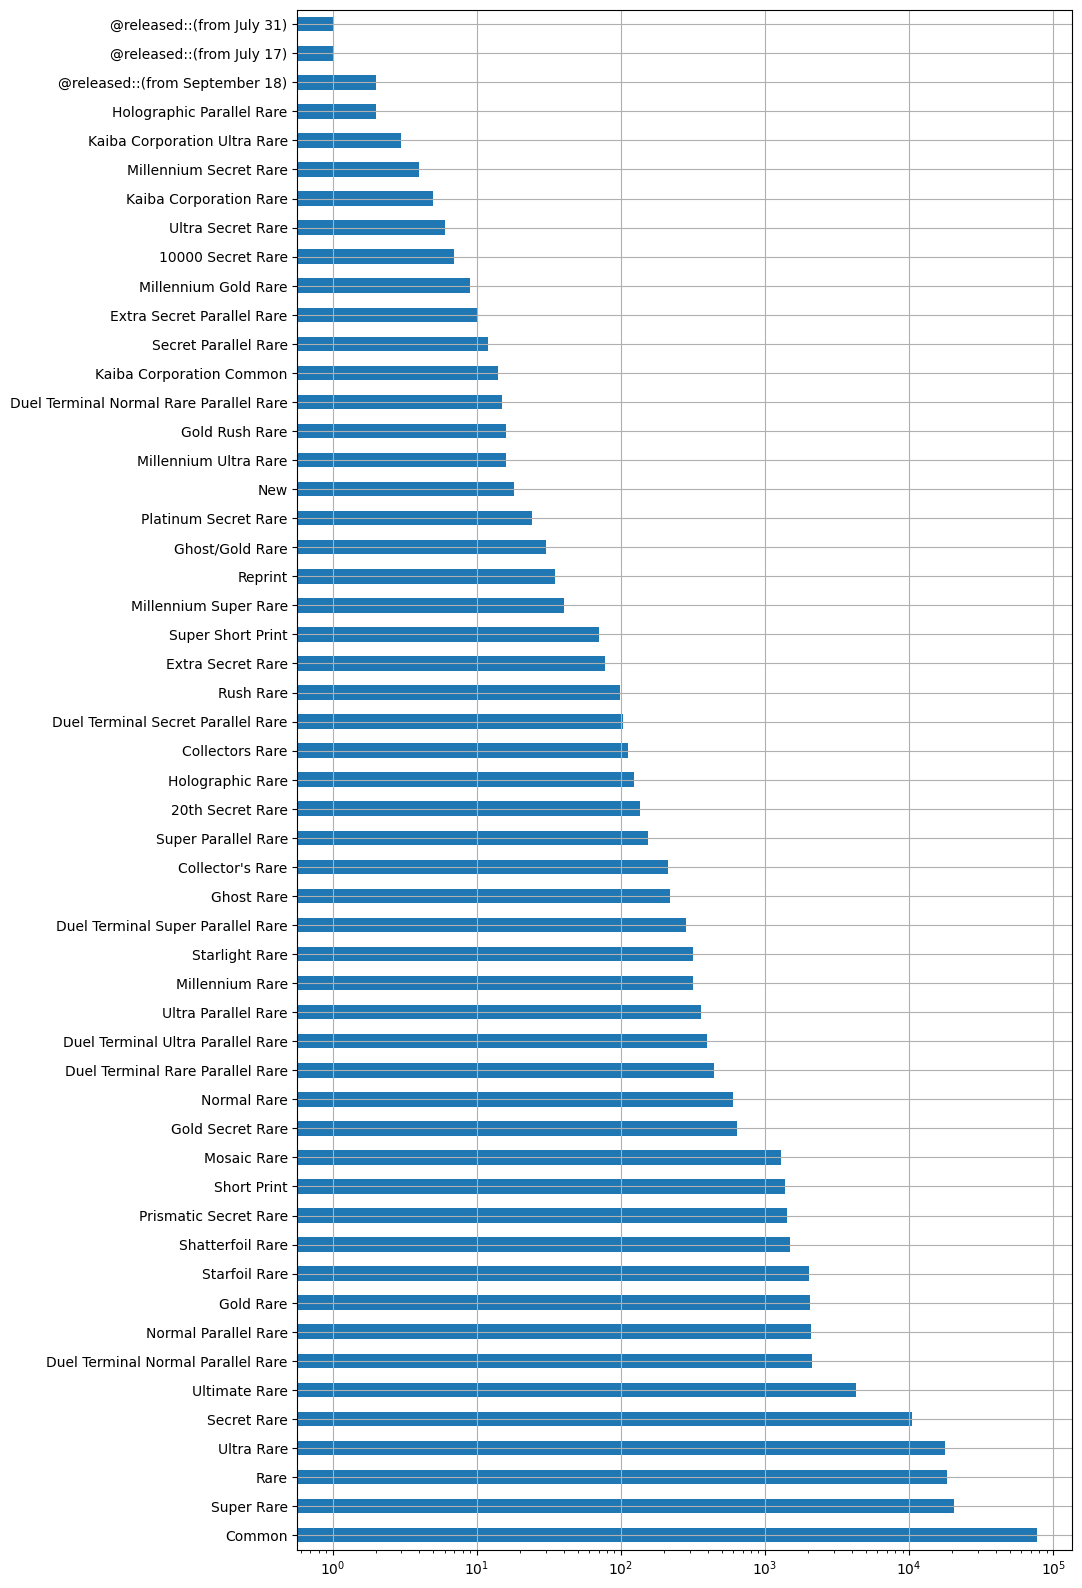

In [19]:
all_set_lists_df['Rarity'].explode().value_counts().plot.barh(figsize = (10,20), grid=True)
plt.xscale('log')
plt.show()

### By combination

In [20]:
all_set_lists_df.groupby('Rarity', dropna = False).nunique()

Set  Card number  Name  \
Rarity                                                                     
(10000 Secret Rare,)                                2            7     1   
(20th Secret Rare,)                                 9           25    24   
(@released::(from July 17),)                        1            1     1   
(@released::(from July 31),)                        1            1     1   
(@released::(from September 18),)                   1            2     1   
...                                               ...          ...   ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)    1            1     1   
(Ultra Rare, Ultra Parallel Rare)                  22           71    67   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)    5            5     5   
(Ultra Secret Rare,)                                1            0     6   
NaN                                                37          428   392   

                                                  Print  Quantity  Region  \
Rarity                                                                      
(10000 Secret Rare,)                                  1         0       7   
(20th Secret Rare,)                                   1         0       1   
(@released::(from July 17),)                          0         0       1   
(@released::(from July 31),)                          0         0       1   
(@released::(from September 18),)                     0         0       1   
...                                                 ...       ...     ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)      0         0       1   
(Ultra Rare, Ultra Parallel Rare)                     0         0       1   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)      0         0       1   
(Ultra Secret Rare,)                                  0         0       1   
NaN                                                   2         0       6   

                                                  Release  Cover card  Series  \
Rarity                                                                          
(10000 Secret Rare,)                                    2           2       1   
(20th Secret Rare,)                                     8           1       2   
(@released::(from July 17),)                            0           0       0   
(@released::(from July 31),)                            0           0       0   
(@released::(from September 18),)                       0           0       0   
...                                                   ...         ...     ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)        1           1       1   
(Ultra Rare, Ultra Parallel Rare)                      16          16       3   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)        3           3       2   
(Ultra Secret Rare,)                                    1           0       1   
NaN                                                    31           6       5   

                                                  Set type  Modification date  \
Rarity                                                                          
(10000 Secret Rare,)                                     1                  2   
(20th Secret Rare,)                                      3                  9   
(@released::(from July 17),)                             0                  1   
(@released::(from July 31),)                             0                  1   
(@released::(from September 18),)                        0                  1   
...                                                    ...                ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)         1                  1   
(Ultra Rare, Ultra Parallel Rare)                        2                 21   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)         1                  5   
(Ultra Secret Rare,)                                     1                  1   
NaN                              

In [21]:
all_set_lists_df['Rarity'].value_counts().plot.barh(figsize = (10,40), grid=True)
plt.xscale('log')
plt.show()

## By Print

In [22]:
print('Total number of prints:', all_set_lists_df['Print'].nunique())

Total number of prints: 14


In [23]:
all_set_lists_df.groupby('Print', dropna=False).nunique()

Set  Card number   Name  Rarity  Quantity  \
Print                                                                     
2                               1            0      1       0         0   
European & Oceanian debut       1            6      6       1         0   
European debut                 12          146    146       5         0   
Functional errata               1            2      2       1         0   
New                           201        10995   3702      46         3   
New art                         1            4      2       1         0   
New artwork                     8           57     14       3         0   
New artwork (renamed)           1            3      3       1         0   
North American debut            2            4      4       2         0   
Oceanian debut                  1            1      1       1         0   
Reprint                       200        11645   4200      46         3   
Reprint (New Art)               2            2      1       2         0   
Reprint (functional errata)    15           33     21      10         0   
Reprint (renamed)               2           76     76       6         0   
<NA>                         1371       126503  11377     112         3   

                             Region  Release  Cover card  Series  Set type  \
Print                                                                        
2                                 1        1           1       0         1   
European & Oceanian debut         1        1           0       0         1   
European debut                    2       10           1       0         2   
Functional errata                 1        1           1       0         1   
New                              11      217         127      16        12   
New art                           2        2           1       0         1   
New artwork                       7       10           4       2         4   
New artwork (renamed)             1        1           0       0         1   
North American debut              2        2           0       0         2   
Oceanian debut                    1        1           0       0         1   
Reprint                          11      216         127      16        11   
Reprint (New Art)                 2        2           1       1         1   
Reprint (functional errata)       8       14           5       3         3   
Reprint (renamed)                 1        2           0       1         1   
<NA>                             17     1459         315      41        37   

                             Modification date  _merge  
Print                                                   
2                                            1       1  
European & Oceanian debut                    1       1  
European debut                              12       1  
Functional errata                            1       1  
New                                        199       2  
New art                                      1       1  
New artwork                                  8       1  
New artwork (renamed)                        1       1  
North American debut                         2       1  
Oceanian debut                               1       1  
Reprint                                    198       2  
Reprint (New Art)                            2       1  
Reprint (functional errata)                 15       1  
Reprint (renamed)                            2       1  
<NA>                                      1363       3

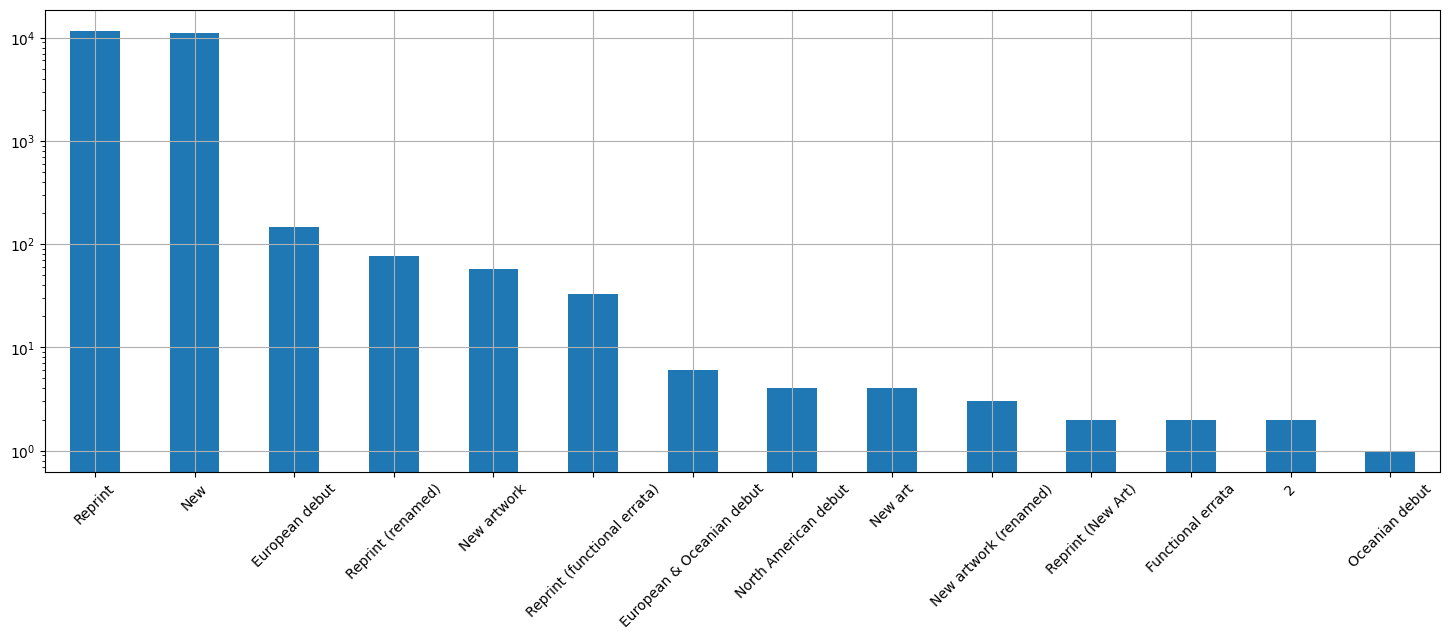

In [24]:
all_set_lists_df['Print'].value_counts().plot.bar(figsize = (18,6), grid=True, rot = 45)
plt.yscale('log')
plt.show()

## By Quantity

In [25]:
print('Total number of quantities:', all_set_lists_df['Quantity'].nunique())

Total number of quantities: 3


In [26]:
all_set_lists_df.groupby('Quantity', dropna=False).nunique()

Set  Card number   Name  Rarity  Print  Region  Release  \
Quantity                                                             
1           67         8858   1215      11      2      11      108   
2           66          855    173       4      2      11      108   
3           10           74     25       1      2       8       12   
<NA>      1375       139556  12352     122     14      17     1500   

          Cover card  Series  Set type  Modification date  _merge  
Quantity                                                           
1                 46       1         6                 66       2  
2                 45       1         6                 65       2  
3                  8       0         4                 10       1  
<NA>             313      45        36               1367       3

## By Region

In [27]:
print('Total number of regions:', all_set_lists_df['Region'].nunique())

Total number of regions: 17


In [28]:
all_set_lists_df.groupby('Region', dropna=False).nunique()

Set  Card number   Name  Rarity  Print  Quantity  Release  Cover card  \
Region                                                                          
AE       34         1527   1493      12      0         2       31          19   
AU        2          100     87       3      0         0        0           2   
DE      452        19854  10217      45      4         3      380         217   
EN      657        20183  10444      51     12         3      535         207   
ES        1          100    100       7      0         0        0           1   
EU       25          543    456       8      3         0       15           6   
FC        3          102     87       3      0         0        1           2   
FR      447        19444  10273      46      4         3      375         218   
IT      444        19533  10212      46      4         3      375         216   
JA        3          185    185       8      0         0        3           3   
JP      721        19155  11105      91      7         3      532         246   
KR      382        15826  10648      55      4         3      332         222   
NA       47         1526   1333      10      3         2       39          12   
PT      201        11943   7637      40      4         3      163         118   
SC       21         1031    984      11      2         0       21          12   
SP      413        18593  10044      45      4         3      353         202   
TC        7          300    286      12      0         2        5           3   
<NA>      2            0      0       0      0         0        0           0   

        Series  Set type  Modification date  _merge  
Region                                               
AE           2         7                 34       1  
AU           0         1                  2       1  
DE          12        18                451       2  
EN          22        23                656       2  
ES           1         1                  1       1  
EU           2         9                 25       1  
FC           0         2                  3       1  
FR          14        18                446       2  
IT          12        18                443       2  
JA           2         2                  3       1  
JP          28        28                716       2  
KR          16        15                377       2  
NA           5        11                 47       1  
PT           8        10                201       1  
SC           5         1                 21       1  
SP           9        17                412       2  
TC           2         2                  7       1  
<NA>         0         0                  2       1

In [29]:
all_set_lists_df.groupby('Region', dropna=False).nunique().describe()

Set   Card number          Name     Rarity      Print  \
count   18.000000     18.000000     18.000000  18.000000  18.000000   
mean   214.555556   8330.277778   4755.055556  27.388889   2.833333   
std    252.694473   9152.121489   4955.826404  25.426107   3.129556   
min      1.000000      0.000000      0.000000   0.000000   0.000000   
25%      4.000000    213.750000    210.250000   8.000000   0.000000   
50%     40.500000   1526.500000   1413.000000  12.000000   3.000000   
75%    436.250000  19014.500000  10215.750000  45.750000   4.000000   
max    721.000000  20183.000000  11105.000000  91.000000  12.000000   

        Quantity     Release  Cover card     Series   Set type  \
count  18.000000   18.000000   18.000000  18.000000  18.000000   
mean    1.666667  175.555556   94.777778   7.777778  10.166667   
std     1.414214  203.604063  105.067796   8.156957   8.759868   
min     0.000000    0.000000    0.000000   0.000000   0.000000   
25%     0.000000    3.500000    3.000000   2.000000   2.000000   
50%     2.000000   35.000000   15.500000   5.000000   9.500000   
75%     3.000000  369.500000  213.750000  12.000000  17.750000   
max     3.000000  535.000000  246.000000  28.000000  28.000000   

       Modification date     _merge  
count          18.000000  18.000000  
mean          213.722222   1.388889  
std           251.600712   0.501631  
min             1.000000   1.000000  
25%             4.000000   1.000000  
50%            40.500000   1.000000  
75%           435.250000   2.000000  
max           716.000000   2.000000

In [30]:
all_set_lists_df['Region'].value_counts().plot.bar(figsize = (18,6), grid=True, rot=0)
plt.show()

## By Cover card

In [45]:
print('Total number of cover cards:', set_info_df['Cover card'].explode('Cover card').nunique())

Total number of cover cards: 668


In [46]:
set_info_df.reset_index(names=['Set']).explode('Cover card').groupby('Cover card').nunique()

Set  Series  Set type  Modification date  \
Cover card                                                                   
A-to-Z-Dragon Buster Cannon         1       0         1                  1   
Accel Synchro Stardust Dragon       1       0         1                  1   
Accesscode Talker                   1       1         1                  1   
Adamancipator Risen - Dragite       1       0         1                  1   
Adreus, Keeper of Armageddon        1       0         1                  1   
...                               ...     ...       ...                ...   
Yamiterasu the Divine Delayer       1       1         1                  1   
Yoko, the Graceful Mayakashi        2       0         1                  2   
Yubel - The Ultimate Nightmare      2       1         2                  2   
Z-Metal Tank                        1       1         1                  1   
Zerrziel, Ruler of the Evil Eyed    1       0         1                  1   

                                  Spanish release date  \
Cover card                                               
A-to-Z-Dragon Buster Cannon                          1   
Accel Synchro Stardust Dragon                        0   
Accesscode Talker                                    1   
Adamancipator Risen - Dragite                        0   
Adreus, Keeper of Armageddon                         0   
...                                                ...   
Yamiterasu the Divine Delayer                        0   
Yoko, the Graceful Mayakashi                         1   
Yubel - The Ultimate Nightmare                       1   
Z-Metal Tank                                         0   
Zerrziel, Ruler of the Evil Eyed                     0   

                                  Traditional Chinese release date  \
Cover card                                                           
A-to-Z-Dragon Buster Cannon                                      0   
Accel Synchro Stardust Dragon                                    0   
Accesscode Talker                                                0   
Adamancipator Risen - Dragite                                    0   
Adreus, Keeper of Armageddon                                     0   
...                                                            ...   
Yamiterasu the Divine Delayer                                    0   
Yoko, the Graceful Mayakashi                                     0   
Yubel - The Ultimate Nightmare                                   0   
Z-Metal Tank                                                     0   
Zerrziel, Ruler of the Evil Eyed                                 0   

                                  French-Canadian release date  \
Cover card                                                       
A-to-Z-Dragon Buster Cannon                                  0   
Accel Synchro Stardust Dragon                                0   
Accesscode Talker                                            0   
Adamancipator Risen - Dragite                                0   
Adreus, Keeper of Armageddon                                 0   
...                                                        ...   
Yamiterasu the Divine Delayer                                0   
Yoko, the Graceful Mayakashi                                 0   
Yubel - The Ultimate Nightmare                               0   
Z-Metal Tank                                                 0   
Zerrziel, Ruler of the Evil Eyed                             0   

                                  Japanese release date  Italian release date  \
Cover card                                                                      
A-to-Z-Dragon Buster Cannon                           1                     1   
Accel Synchro Stardust Dragon                         1                     0   
Accesscode Talker                                     1                     1   
Adamancipator Risen - Dragite                         1                     0   
Adreus, 

In [47]:
set_info_df['Cover card'].explode('Cover card').value_counts().plot.barh(figsize = (10,180), grid=True)
plt.show()

## By Set type

In [48]:
print('Total number of set types:', set_info_df['Set type'].explode().nunique())

Total number of set types: 37


In [49]:
set_info_df.reset_index(names=['Set']).explode('Set type').groupby('Set type').nunique()

Set  Cover card  Series  \
Set type                                                      
Beta set                              1           0       0   
Binder                                2           0       0   
Book promotional card                 4           0       1   
Book promotional cards               26           0       2   
Booster pack                        471         222      23   
Boss Duel Deck                        1           0       0   
Bundle                                9           0       1   
Collectible tin                      53          35       0   
Collector's Set                      11           6       0   
Core Booster                          1           1       0   
Deluxe Edition                        4           4       0   
Demo Deck                             4           1       0   
Duel Disk                             2           0       0   
Duel Disk promotional cards           5           0       0   
Duel Terminal                        34          10       0   
Duelist League participation cards   10           0       0   
Duelist Set                           5           5       0   
Enhancement Pack                      2           0       0   
Hobby League participation cards     40           0       0   
Magazine promotional card           167           7       3   
Magazine promotional cards            4           0       0   
Main Deck                             2           1       0   
Manga promotional card               33           0       4   
Participation card                   60           0       2   
Preconstructed Deck                   6           4       0   
Prize card                           16           0       1   
Prize cards                           1           0       0   
Promotional card                    141          21       6   
Promotional cards                    25           1       1   
Special Edition                      90           1       0   
Starter Deck                         38          26       0   
Structure Deck                       64          45       1   
Tournament prize card                 1           0       0   
Tournament promotional card           2           0       0   
Vendor Edition                        6           0       0   
Video game promotional card           9           0       0   
Video games promotional card         23           0       0   

                                    Modification date  Spanish release date  \
Set type                                                                      
Beta set                                            1                     1   
Binder                                              2                     0   
Book promotional card                               4                     0   
Book promotional cards                             26                     0   
Booster pack                                      471                   160   
Boss Duel Deck                                      1                     0   
Bundle                                              9                     0   
Collectible tin                                    53                    29   
Collector's Set                                    11                     8   
Core Booster                                        1                     1   
Deluxe Edition                                      4                     4   
Demo Deck                                           4                     2   
Duel Disk                                           2                     0   
Duel Disk promotional cards                         5                     0   
Duel Terminal                                      34                     0   
Duelist League participation cards                 10                     6   
Duelist Set                                         5                     0   
Enhancement Pack                                    2                     0  

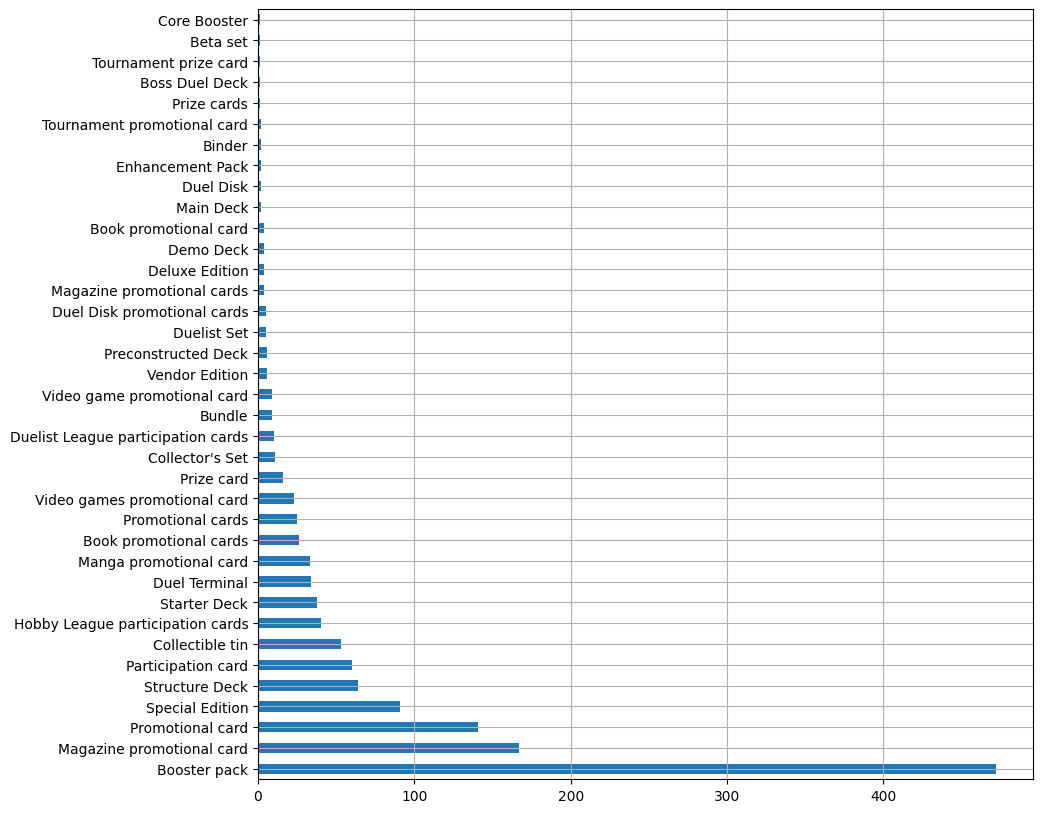

In [50]:
set_info_df['Set type'].explode('Set type').value_counts().plot.barh(figsize = (10,10), grid=True)
plt.show()

## By Release

In [31]:
print('Total number of release dates:', all_set_lists_df['Release'].nunique())

Total number of release dates: 1571


In [32]:
all_set_lists_df.groupby('Release', dropna=False).nunique()

Set  Card number  Name  Rarity  Print  Quantity  Region  \
Release                                                               
1999-03-01    1            0    40       1      0         0       1   
1999-03-18    1            0     1       0      0         0       1   
1999-04-29    1            0     1       0      0         0       1   
1999-05-05    1            0     1       0      0         0       1   
1999-05-25    1            0    40       1      0         0       1   
...         ...          ...   ...     ...    ...       ...     ...   
2023-01-19    1           60     3       1      0         0       1   
2023-01-21    1           67     3       2      0         0       1   
2023-03-01    1            1     1       1      0         0       1   
2023-05-01    2            2     2       1      0         0       1   
NaT         125         4413  1294      28      4         2      15   

            Cover card  Series  Set type  Modification date  _merge  
Release                                                              
1999-03-01           0       1         1                  1       1  
1999-03-18           0       0         1                  1       1  
1999-04-29           0       0         1                  1       1  
1999-05-05           0       0         1                  1       1  
1999-05-25           0       1         1                  1       1  
...                ...     ...       ...                ...     ...  
2023-01-19           1       0         1                  1       1  
2023-01-21           0       1         1                  1       1  
2023-03-01           0       0         1                  1       1  
2023-05-01           0       0         1                  2       1  
NaT                 19       9        14                117       3  

[1572 rows x 12 columns]

In [33]:
set_by_date = pd.DataFrame(all_set_lists_df.groupby('Release', dropna=False)['Set'].nunique())

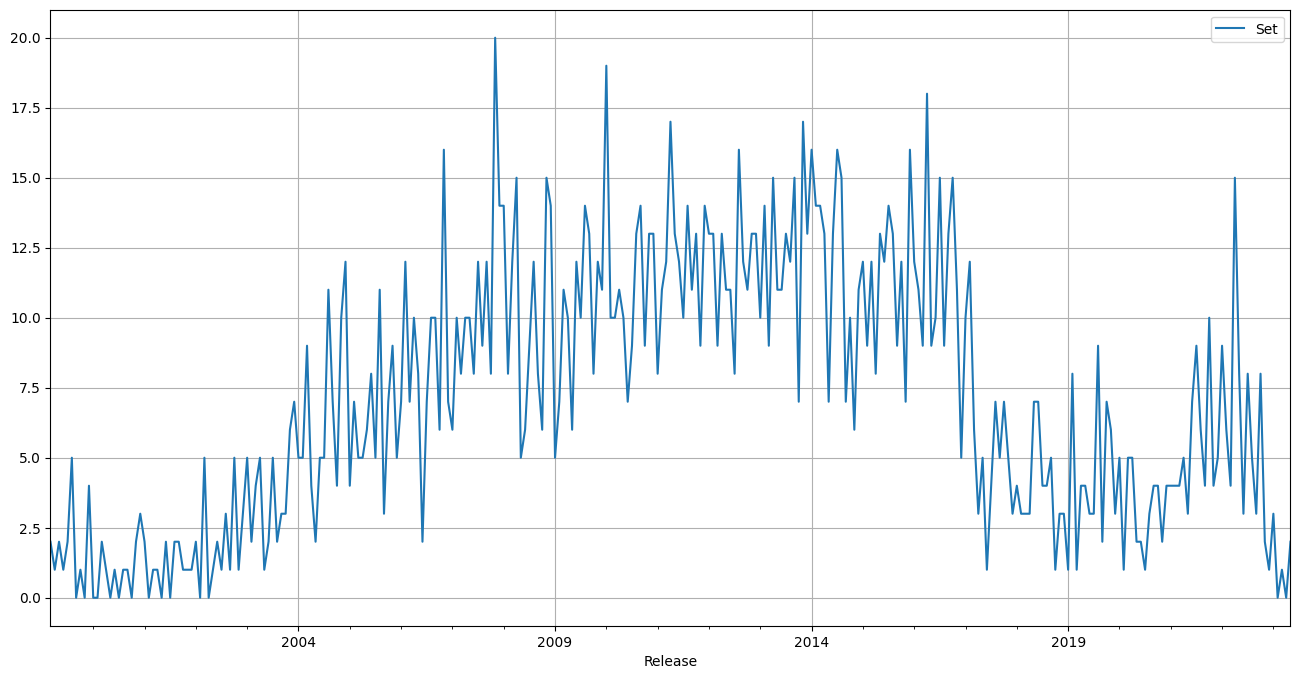

In [34]:
set_by_date.resample('M').sum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

In [35]:
set_by_date.resample('Y').sum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

In [36]:
set_by_date.groupby(set_by_date.index.strftime('%Y')).sum().plot.bar(figsize= (16,8), grid=True, xlabel = 'Release year', rot = 45)
plt.show()

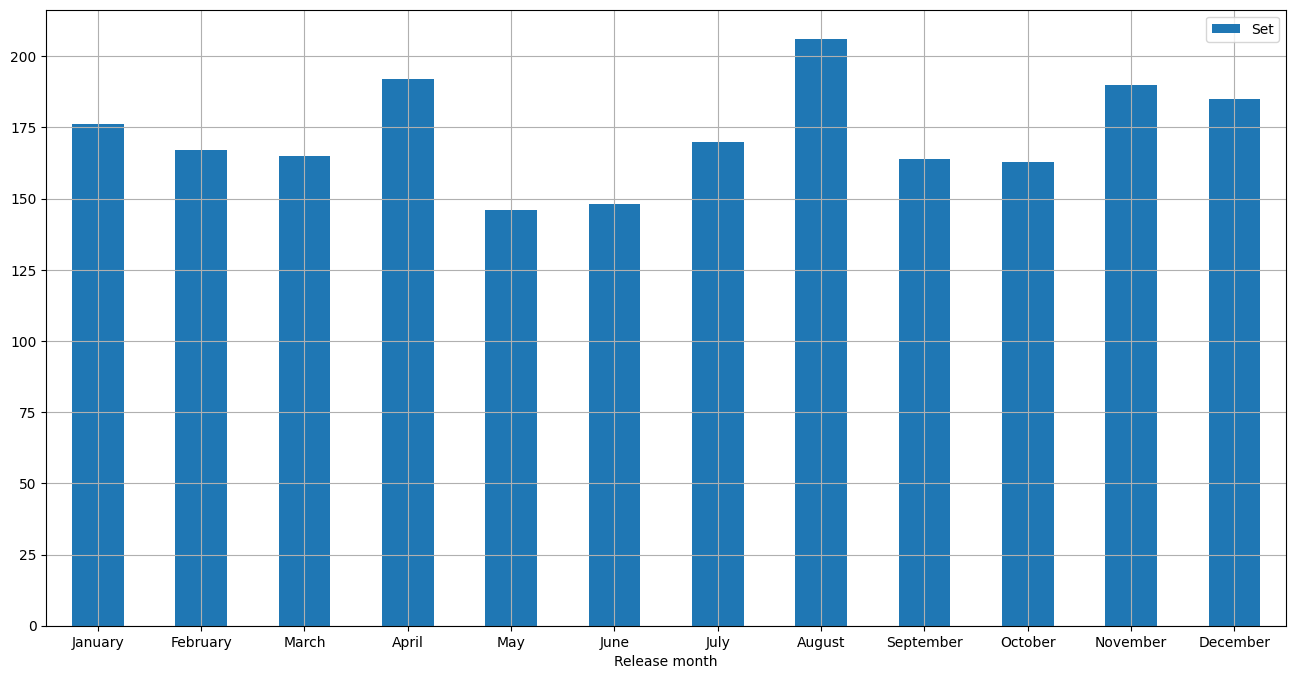

In [37]:
set_by_date.groupby(set_by_date.index.strftime('%B')).sum().sort_index(key=lambda x: pd.to_datetime(x, format='%B').month).plot.bar(figsize= (16,8), grid=True, xlabel = 'Release month', rot = 0)
plt.show()

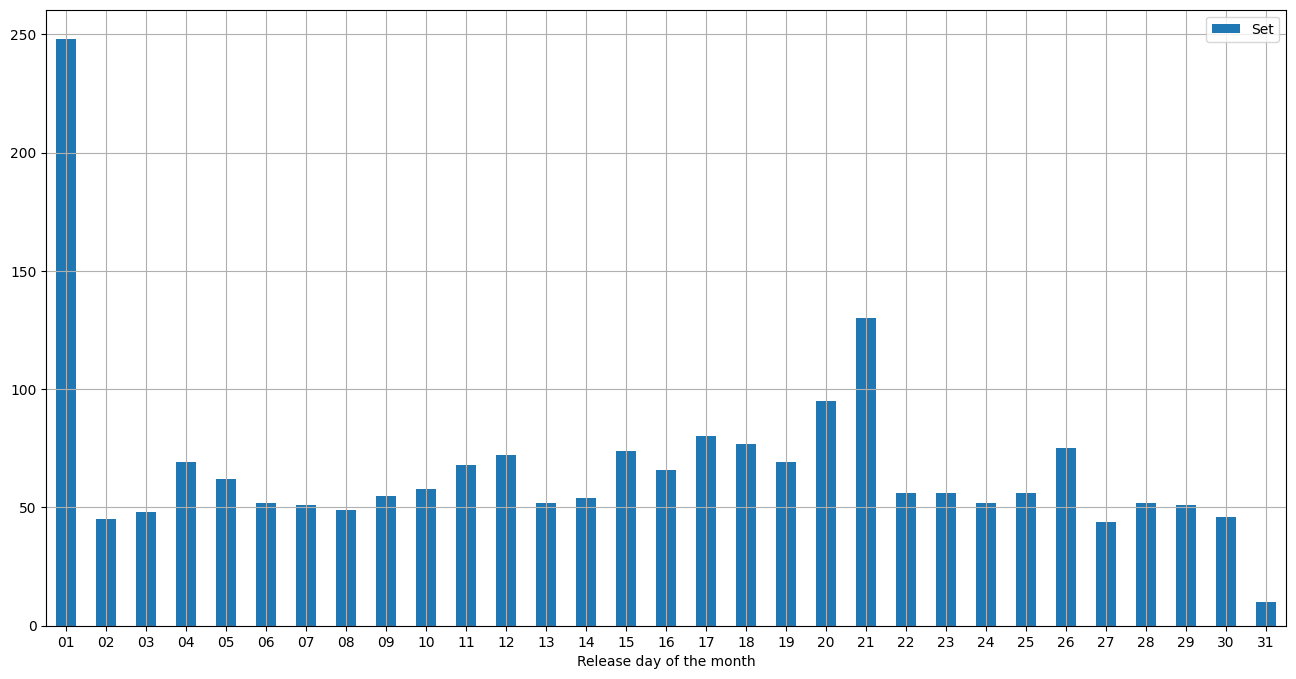

In [38]:
set_by_date.groupby(set_by_date.index.strftime('%d')).sum().plot.bar(figsize= (16,8), grid=True, xlabel = 'Release day of the month', rot = 0)
plt.show()

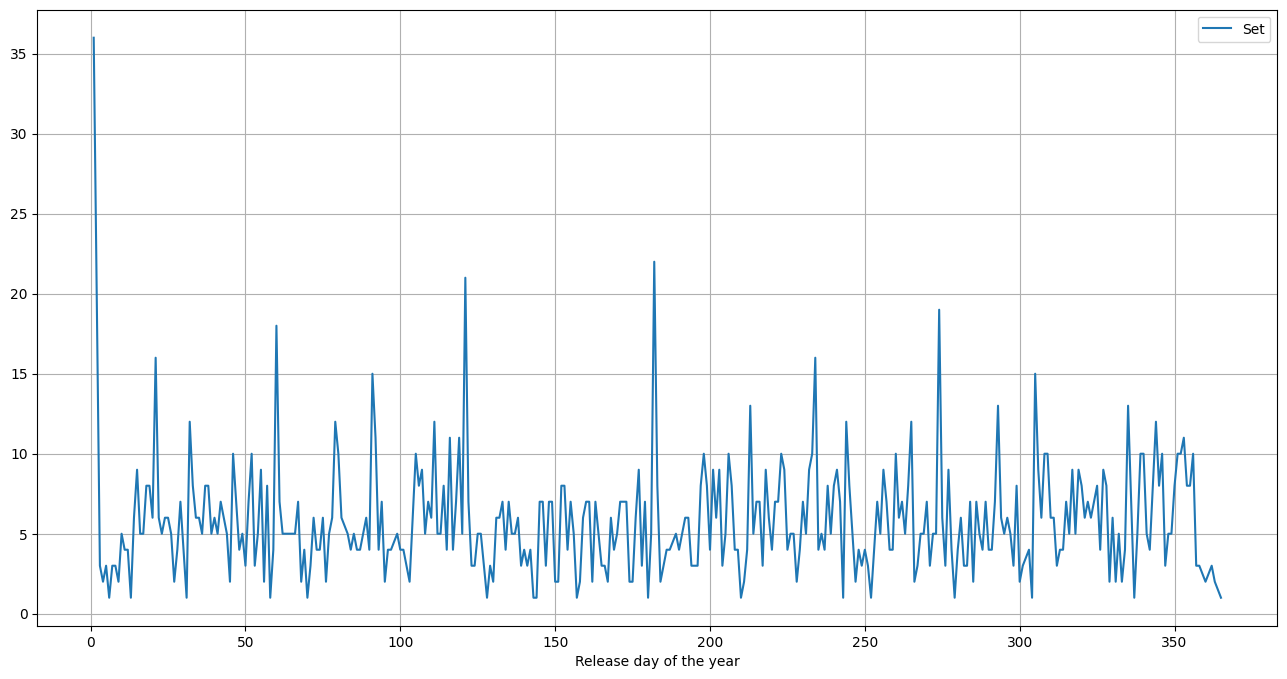

In [39]:
set_by_date.groupby(set_by_date.index.dayofyear).sum().plot(figsize= (16,8), grid=True, xlabel = 'Release day of the year')
plt.show()

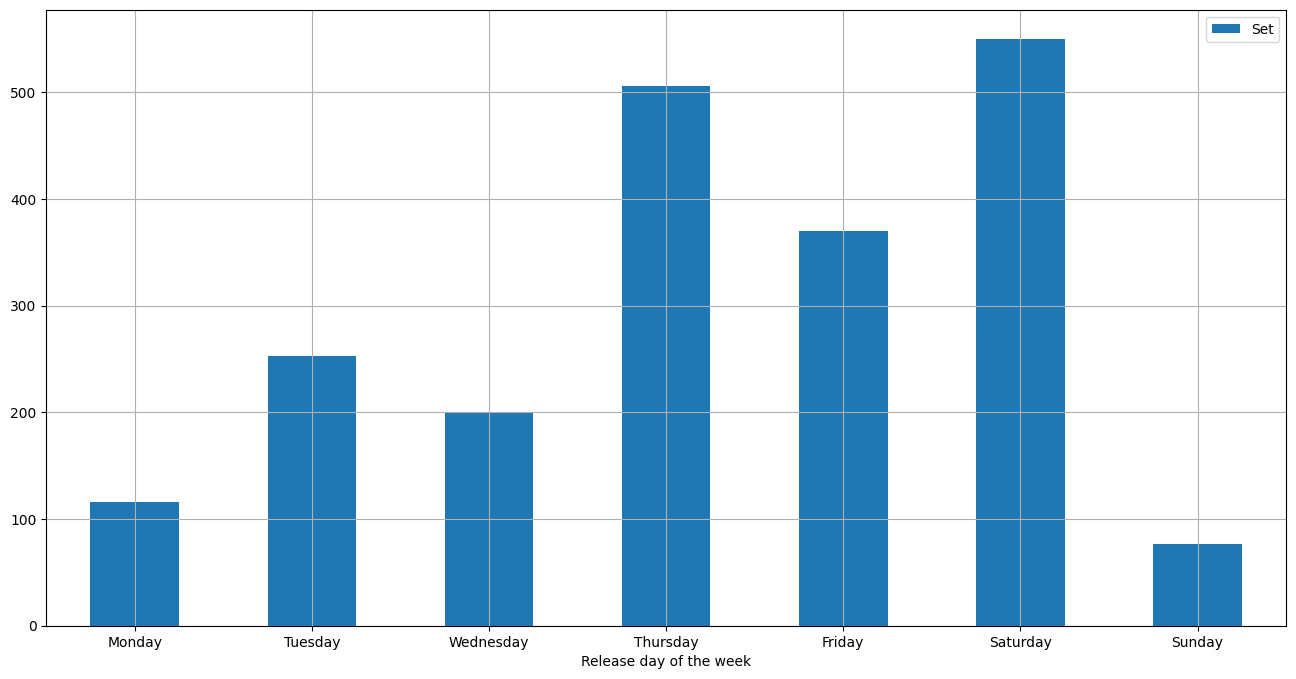

In [40]:
test = set_by_date.groupby(set_by_date.index.weekday).sum()
test.index = [calendar.day_name[i] for i in test.index.astype(int)]
# test.index
test.plot.bar(figsize= (16,8), grid=True, xlabel = 'Release day of the week', rot = 0)

plt.show()

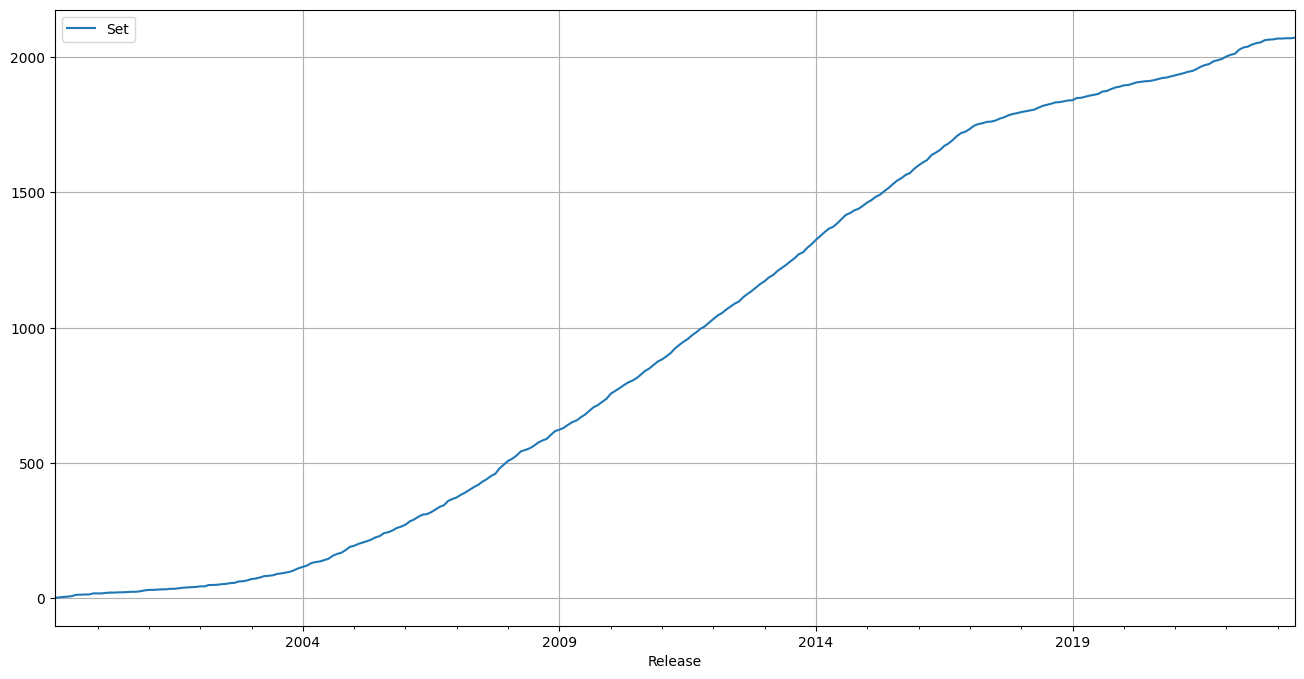

In [41]:
set_by_date.resample('M').sum().cumsum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

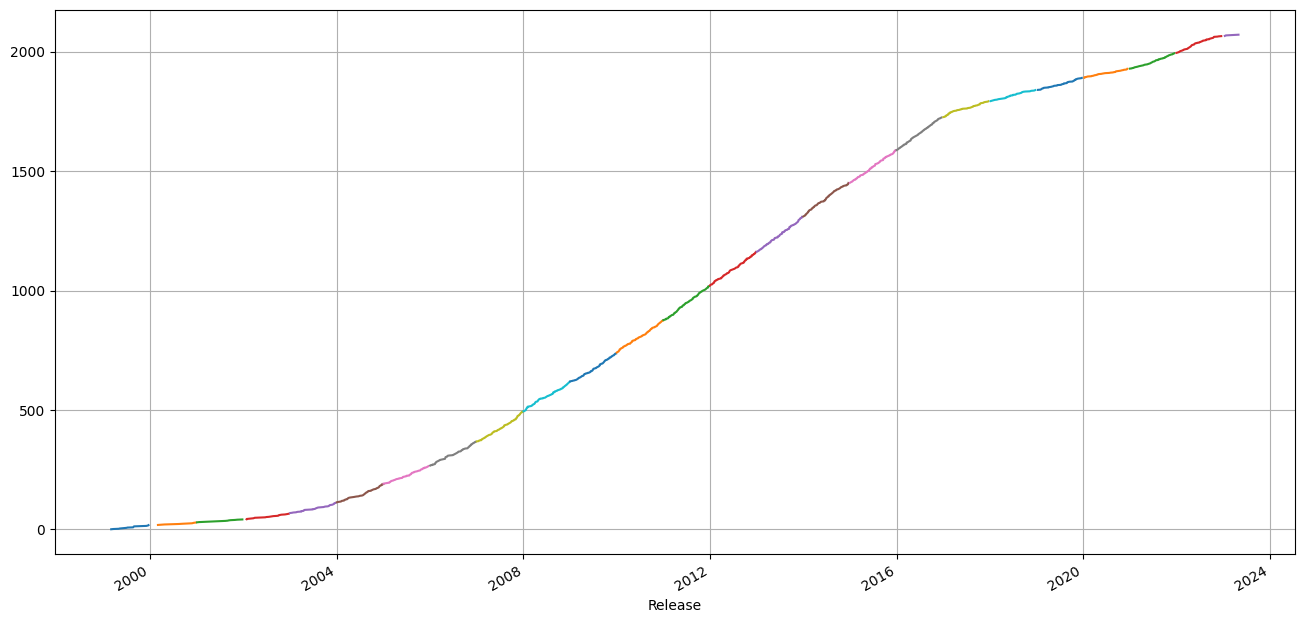

In [42]:
cumsum_df = set_by_date.groupby([set_by_date.index.year, set_by_date.index]).sum().cumsum().unstack(level=0)
cumsum_df.columns = cumsum_df.columns.droplevel(level=0)
cumsum_df.plot(figsize = (16,8), grid = True, legend = False)
plt.show()

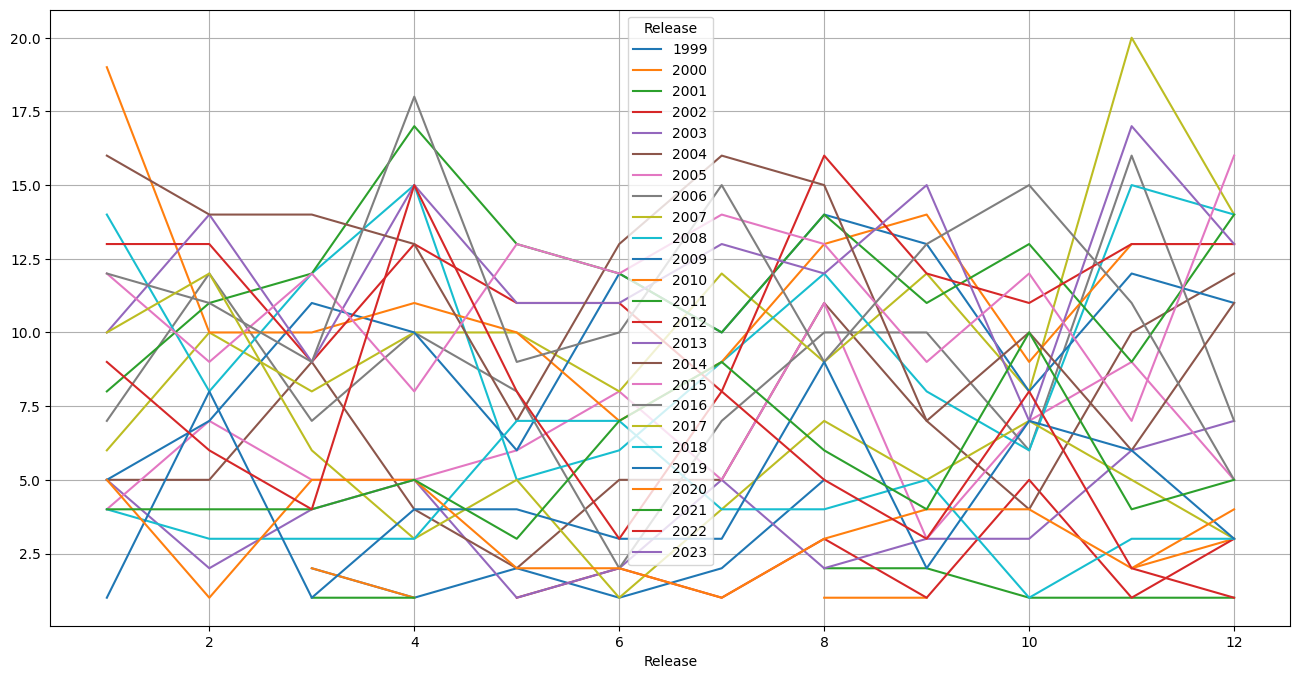

In [43]:
sum_month_df = set_by_date.groupby([set_by_date.index.year, set_by_date.index.month]).sum().unstack(level=0)
sum_month_df.columns = sum_month_df.columns.droplevel(level=0).astype(int)
sum_month_df.plot(figsize = (16,8), grid = True, legend = True)
plt.show()

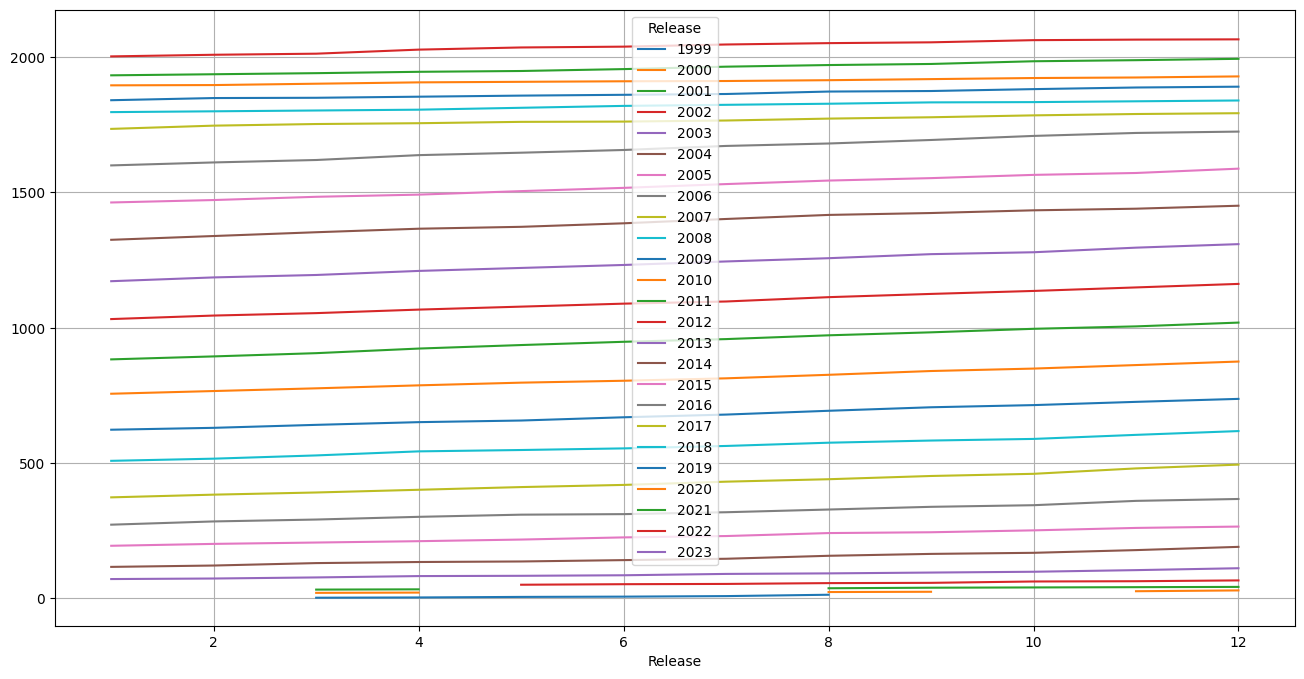

In [44]:
cumsum_month_df = set_by_date.groupby([set_by_date.index.year, set_by_date.index.month]).sum().cumsum().unstack(level=0)
cumsum_month_df.columns = cumsum_month_df.columns.droplevel(level=0).astype(int)
cumsum_month_df.plot(figsize = (16,8), grid = True)
plt.show()

# Debug

## Has nan name/number

In [51]:
all_set_lists_df[all_set_lists_df['Name'].isna() | all_set_lists_df['Card number'].isna()]

Set Card number  \
12469                                Booster 5        <NA>   
12470                                Booster 5        <NA>   
12471                                Booster 5        <NA>   
12472                                Booster 5        <NA>   
12473                                Booster 5        <NA>   
...                                        ...         ...   
143174                          EX Starter Box        <NA>   
143175                          EX Starter Box        <NA>   
143176                          EX Starter Box        <NA>   
153489                           Academia Disk        <NA>   
153490  Structure Deck: Marik (disambiguation)        <NA>   

                       Name     Rarity    Print  Quantity Region    Release  \
12469   Two-Headed King Rex  (Common,)     <NA>      <NA>     JP 1999-10-17   
12470        The Snake Hair  (Common,)     <NA>      <NA>     JP 1999-10-17   
12471                  Wolf  (Common,)     <NA>      <NA>     JP 1999-10-17   
12472            Krokodilus  (Common,)     <NA>      <NA>     JP 1999-10-17   
12473    Crawling Dragon #2  (Common,)     <NA>      <NA>     JP 1999-10-17   
...                     ...        ...      ...       ...    ...        ...   
143174             De-Spell       None        2      <NA>     JP 1999-12-16   
143175         Castle Walls       None  Reprint      <NA>     JP 1999-12-16   
143176    Ultimate Offering       None  Reprint      <NA>     JP 1999-12-16   
153489                 <NA>        NaN     <NA>      <NA>   <NA>        NaT   
153490                 <NA>        NaN     <NA>      <NA>   <NA>        NaT   

                       Cover card           Series         Set type  \
12469                         NaN  (Core Booster,)  (Booster pack,)   
12470                         NaN  (Core Booster,)  (Booster pack,)   
12471                         NaN  (Core Booster,)  (Booster pack,)   
12472                         NaN  (Core Booster,)  (Booster pack,)   
12473                         NaN  (Core Booster,)  (Booster pack,)   
...                           ...              ...              ...   
143174  (Blue-Eyes White Dragon,)              NaN  (Starter Deck,)   
143175  (Blue-Eyes White Dragon,)              NaN  (Starter Deck,)   
143176  (Blue-Eyes White Dragon,)              NaN  (Starter Deck,)   
153489                        NaN              NaN              NaN   
153490                        NaN              NaN              NaN   

         Modification date      _merge  
12469  2022-07-23 09:59:22        both  
12470  2022-07-23 09:59:22        both  
12471  2022-07-23 09:59:22        both  
12472  2022-07-23 09:59:22        both  
12473  2022-07-23 09:59:22        both  
...                    ...         ...  
143174 2022-05-01 06:51:59        both  
143175 2022-05-01 06:51:59        both  
143176 2022-05-01 06:51:59        both  
153489 2022-01-04 11:09:58  right_only  
153490 2014-07-03 18:52:14  right_only  

[758 rows x 13 columns]

## Has nan rarity

In [52]:
all_set_lists_df.explode('Rarity')[all_set_lists_df.explode('Rarity')['Rarity'].isna()]['Set'].unique()

array(['Dark Revelation Volume 2', 'Advanced Tournament Pack 2013 Vol.3',
       'Dark Beginning 1', 'V Jump April 2013 Tokens', 'Dark Beginning 2',
       'Dark Revelation Volume 1',
       'Yu-Gi-Oh! Duel Monsters II: Dark duel Stories Duelist Legend in Tokyo Dome prize cards',
       'Advanced Event Pack 2013 Vol.2',
       'Duel Monsters II tournament meeting experience promotional card',
       'Yu-Gi-Oh! Duel Monsters II: Dark duel Stories Duelist Legend in Tokyo Dome participation cards',
       'Advanced Tournament Pack 2013 Vol.4',
       'Official Guide Starter Book promotional card',
       'Advanced Event Pack 2014 Vol.1',
       'Starter Box pre-order promotional card',
       'Advanced Tournament Pack 2016 Vol.1',
       'The Valuable Book 1 promotional cards',
       'Yu-Gi-Oh! Duel Monsters II: Dark duel Stories Duelist Legend in Tokyo Dome attendance cards',
       'Jump Festa 2000', 'The Valuable Book character cards',
       'Yu-Gi-Oh! True Duel Monsters: Sealed Memo

## Has quantity as print

In [53]:
all_set_lists_df[all_set_lists_df['Print']=='2']

Set Card number      Name Rarity Print  Quantity Region  \
143125  EX Starter Box        <NA>  De-Spell   None     2      <NA>     JP   
143174  EX Starter Box        <NA>  De-Spell   None     2      <NA>     JP   

          Release                 Cover card Series         Set type  \
143125 1999-12-16  (Blue-Eyes White Dragon,)    NaN  (Starter Deck,)   
143174 1999-12-16  (Blue-Eyes White Dragon,)    NaN  (Starter Deck,)   

         Modification date _merge  
143125 2022-05-01 06:51:59   both  
143174 2022-05-01 06:51:59   both

In [54]:
all_set_lists_df[all_set_lists_df['Set']=='EX Starter Box']

Set Card number                           Name  Rarity  \
143077  EX Starter Box        <NA>                     Lord of D.  (New,)   
143078  EX Starter Box        <NA>  The Flute of Summoning Dragon  (New,)   
143079  EX Starter Box        <NA>                  Dark Magician    None   
143080  EX Starter Box        <NA>                   Mystical Elf    None   
143081  EX Starter Box        <NA>                      Feral Imp    None   
...                ...         ...                            ...     ...   
143172  EX Starter Box        <NA>                   Reverse Trap    None   
143173  EX Starter Box        <NA>                    Remove Trap    None   
143174  EX Starter Box        <NA>                       De-Spell    None   
143175  EX Starter Box        <NA>                   Castle Walls    None   
143176  EX Starter Box        <NA>              Ultimate Offering    None   

          Print  Quantity Region    Release                 Cover card Series  \
143077     <NA>      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143078     <NA>      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143079     <NA>      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143080     <NA>      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143081     <NA>      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
...         ...       ...    ...        ...                        ...    ...   
143172  Reprint      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143173  Reprint      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143174        2      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143175  Reprint      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   
143176  Reprint      <NA>     JP 1999-12-16  (Blue-Eyes White Dragon,)    NaN   

               Set type   Modification date _merge  
143077  (Starter Deck,) 2022-05-01 06:51:59   both  
143078  (Starter Deck,) 2022-05-01 06:51:59   both  
143079  (Starter Deck,) 2022-05-01 06:51:59   both  
143080  (Starter Deck,) 2022-05-01 06:51:59   both  
143081  (Starter Deck,) 2022-05-01 06:51:59   both  
...                 ...                 ...    ...  
143172  (Starter Deck,) 2022-05-01 06:51:59   both  
143173  (Starter Deck,) 2022-05-01 06:51:59   both  
143174  (Starter Deck,) 2022-05-01 06:51:59   both  
143175  (Starter Deck,) 2022-05-01 06:51:59   both  
143176  (Starter Deck,) 2022-05-01 06:51:59   both  

[100 rows x 13 columns]

## Has nan release

In [55]:
all_set_lists_df[all_set_lists_df['Release'].isna()]['Set'].unique()

array(['Hobby League 7 participation card A',
       'Shonen Jump Vol. 9, Issue 6 promotional card',
       'Starter Deck: Yugi', 'Tournament Pack 2009 Vol.4',
       "Yu-Gi-Oh! 5D's World Championship 2011: Over the Nexus promotional cards",
       'Premium Pack 2', 'Starter Deck: Kaiba', 'Starter Deck: Pegasus',
       'Yu-Gi-Oh! Worldwide Edition: Stairway to the Destined Duel promotional cards',
       'Cosmo Blazer', 'Shonen Jump Vol. 5, Issue 1 promotional card',
       'Shonen Jump Vol. 7, Issue 9 promotional card',
       'Starter Deck: Kaiba Evolution',
       'Yu-Gi-Oh! GX Volume 4 promotional card',
       'Shonen Jump June/July 2011 subscription bonus',
       'Banzai! promotional cards', 'Hobby League 6 participation card B',
       'Invasion: Vengeance Sneak Peek Participation Card',
       'Secrets of Eternity Sneak Peek Participation Card',
       'The Lost Millennium: Special Edition',
       "Yu-Gi-Oh! 5D's Wheelie Breakers promotional cards",
       'Ancient Prophecy

## Has print as rarity

In [56]:
all_set_lists_df.explode('Rarity')[(all_set_lists_df['Rarity'].explode() == 'New') | (all_set_lists_df['Rarity'].explode() == 'Reprint')]['Set'].unique()

array(['Booster 5', 'Structure Deck R: Machine Dragon Re-Volt',
       'Booster 6', 'Booster 7', 'Dark Ceremony Edition', 'Booster 4',
       'Booster 1', 'EX Starter Box'], dtype=object)

## Merge failed

In [57]:
all_set_lists_df[all_set_lists_df['_merge']=='right_only']

Set Card number  Name Rarity Print  \
153489                           Academia Disk        <NA>  <NA>    NaN  <NA>   
153490  Structure Deck: Marik (disambiguation)        <NA>  <NA>    NaN  <NA>   

        Quantity Region Release Cover card Series Set type  \
153489      <NA>   <NA>     NaT        NaN    NaN      NaN   
153490      <NA>   <NA>     NaT        NaN    NaN      NaN   

         Modification date      _merge  
153489 2022-01-04 11:09:58  right_only  
153490 2014-07-03 18:52:14  right_only

In [58]:
len(all_set_lists_df[all_set_lists_df['_merge']=='left_only']['Set'].unique())

8

In [59]:
all_set_lists_df['Set'].unique()

array(['Astral Pack Seven', 'Breakers of Shadow',
       'Champion Pack: Game Six', ..., 'Jump Festa Limited Pack 2020',
       'Academia Disk', 'Structure Deck: Marik (disambiguation)'],
      dtype=object)

In [60]:
all_set_lists_df[all_set_lists_df['Set'].str.contains("Marik")].dropna()

Empty DataFrame
Columns: [Set, Card number, Name, Rarity, Print, Quantity, Region, Release, Cover card, Series, Set type, Modification date, _merge]
Index: []

# HTML export

In [61]:
! jupyter nbconvert Sets.ipynb --output-dir='../' --to=HTML --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='exclude' --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook Sets.ipynb to HTML
[NbConvertApp] Writing 609899 bytes to ../Sets.html


In [62]:
print('Report exported to HTML')

Report exported to HTML


# Git

In [100]:
! git add "../*[Ss]ets*"

In [101]:
! git commit -m {"Sets update-" + pd.Timestamp.now().strftime("%d%m%Y")}

error: pathspec 'update-14122022' did not match any file(s) known to git


In [64]:
! git push

fatal: Failed to locate 'gpg' executable on the path.
Username for 'https://github.com': ^C
